In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


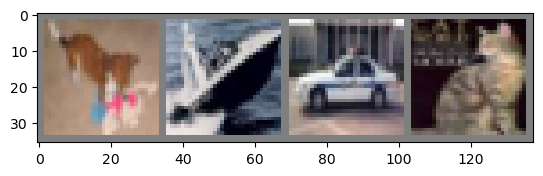

dog   ship  car   cat  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.204
[1,  4000] loss: 1.874
[1,  6000] loss: 1.714
[1,  8000] loss: 1.616
[1, 10000] loss: 1.552
[1, 12000] loss: 1.495
[2,  2000] loss: 1.434
[2,  4000] loss: 1.385
[2,  6000] loss: 1.390
[2,  8000] loss: 1.355
[2, 10000] loss: 1.333
[2, 12000] loss: 1.308
Finished Training


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

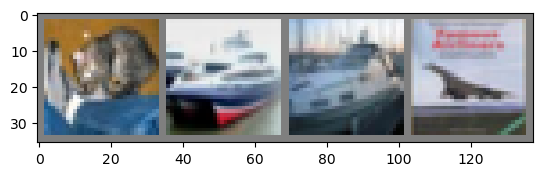

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   ship 


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 50 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 39.0 %
Accuracy for class: car   is 66.1 %
Accuracy for class: bird  is 31.8 %
Accuracy for class: cat   is 63.1 %
Accuracy for class: deer  is 22.8 %
Accuracy for class: dog   is 32.0 %
Accuracy for class: frog  is 64.1 %
Accuracy for class: horse is 43.1 %
Accuracy for class: ship  is 78.1 %
Accuracy for class: truck is 69.1 %


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [16]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
inputs, labels = data[0].to(device), data[1].to(device)

# 00. PyTorch Fundamentals

## What is PyTorch?

[PyTorch](https://pytorch.org/) is an open source machine learning and deep learning framework.

## What can PyTorch be used for?

PyTorch allows you to manipulate and process data and write machine learning algorithms using Python code.

## Who uses PyTorch?

Many of the worlds largest technology companies such as [Meta (Facebook)](https://ai.facebook.com/blog/pytorch-builds-the-future-of-ai-and-machine-learning-at-facebook/), Tesla and Microsoft as well as artificial intelligence research companies such as [OpenAI use PyTorch](https://openai.com/blog/openai-pytorch/) to power research and bring machine learning to their products.

![pytorch being used across industry and research](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/00-pytorch-being-used-across-research-and-industry.png)

For example, Andrej Karpathy (head of AI at Tesla) has given several talks ([PyTorch DevCon 2019](https://youtu.be/oBklltKXtDE), [Tesla AI Day 2021](https://youtu.be/j0z4FweCy4M?t=2904)) about how Tesla use PyTorch to power their self-driving computer vision models.

PyTorch is also used in other industries such as agriculture to [power computer vision on tractors](https://medium.com/pytorch/ai-for-ag-production-machine-learning-for-agriculture-e8cfdb9849a1).

## Why use PyTorch?

Machine learning researchers love using PyTorch. And as of February 2022, PyTorch is the [most used deep learning framework on Papers With Code](https://paperswithcode.com/trends), a website for tracking machine learning research papers and the code repositories attached with them.

PyTorch also helps take care of many things such as GPU acceleration (making your code run faster) behind the scenes.

So you can focus on manipulating data and writing algorithms and PyTorch will make sure it runs fast.

And if companies such as Tesla and Meta (Facebook) use it to build models they deploy to power hundreds of applications, drive thousands of cars and deliver content to billions of people, it's clearly capable on the development front too.

## What we're going to cover in this module

This course is broken down into different sections (notebooks).

Each notebook covers important ideas and concepts within PyTorch.

Subsequent notebooks build upon knowledge from the previous one (numbering starts at 00, 01, 02 and goes to whatever it ends up going to).

This notebook deals with the basic building block of machine learning and deep learning, the tensor.

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **Introduction to tensors** | Tensors are the basic building block of all of machine learning and deep learning. |
| **Creating tensors** | Tensors can represent almost any kind of data (images, words, tables of numbers). |
| **Getting information from tensors** | If you can put information into a tensor, you'll want to get it out too. |
| **Manipulating tensors** | Machine learning algorithms (like neural networks) involve manipulating tensors in many different ways such as adding, multiplying, combining. |
| **Dealing with tensor shapes** | One of the most common issues in machine learning is dealing with shape mismatches (trying to mixed wrong shaped tensors with other tensors). |
| **Indexing on tensors** | If you've indexed on a Python list or NumPy array, it's very similar with tensors, except they can have far more dimensions. |
| **Mixing PyTorch tensors and NumPy** | PyTorch plays with tensors ([`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html)), NumPy likes arrays ([`np.ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html)) sometimes you'll want to mix and match these. |
| **Reproducibility** | Machine learning is very experimental and since it uses a lot of *randomness* to work, sometimes you'll want that *randomness* to not be so random. |
| **Running tensors on GPU** | GPUs (Graphics Processing Units) make your code faster, PyTorch makes it easy to run your code on GPUs. |

## Where can you get help?

All of the materials for this course [live on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

And if you run into trouble, you can ask a question on the [Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions) there too.

There's also the [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch.

## Importing PyTorch

> **Note:** Before running any of the code in this notebook, you should have gone through the [PyTorch setup steps](https://pytorch.org/get-started/locally/).
>
> However, **if you're running on Google Colab**, everything should work (Google Colab comes with PyTorch and other libraries installed).

Let's start by importing PyTorch and checking the version we're using.

In [5]:
import torch
torch.__version__

'2.0.1'

Wonderful, it looks like we've got PyTorch 1.10.0+.

This means if you're going through these materials, you'll see most compatability with PyTorch 1.10.0+, however if your version number is far higher than that, you might notice some inconsistencies.

And if you do have any issues, please post on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

## Introduction to tensors

Now we've got PyTorch imported, it's time to learn about tensors.

Tensors are the fundamental building block of machine learning.

Their job is to represent data in a numerical way.

For example, you could represent an image as a tensor with shape `[3, 224, 224]` which would mean `[colour_channels, height, width]`, as in the image has `3` colour channels (red, green, blue), a height of `224` pixels and a width of `224` pixels.

![example of going from an input image to a tensor representation of the image, image gets broken down into 3 colour channels as well as numbers to represent the height and width](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/00-tensor-shape-example-of-image.png)

In tensor-speak (the language used to describe tensors), the tensor would have three dimensions, one for `colour_channels`, `height` and `width`.

But we're getting ahead of ourselves.

Let's learn more about tensors by coding them.


### Creating tensors

PyTorch loves tensors. So much so there's a whole documentation page dedicated to the [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) class.

Your first piece of homework is to [read through the documentation on `torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) for 10-minutes. But you can get to that later.

Let's code.

The first thing we're going to create is a **scalar**.

A scalar is a single number and in tensor-speak it's a zero dimension tensor.

> **Note:** That's a trend for this course. We'll focus on writing specific code. But often I'll set exercises which involve reading and getting familiar with the PyTorch documentation. Because after all, once you're finished this course, you'll no doubt want to learn more. And the documentation is somewhere you'll be finding yourself quite often.

In [6]:
# Scalar
scalar = torch.tensor(7)
scalar

tensor(7)

See how the above printed out `tensor(7)`?

That means although `scalar` is a single number, it's of type `torch.Tensor`.

We can check the dimensions of a tensor using the `ndim` attribute.

In [7]:
scalar.ndim

0

What if we wanted to retrieve the number from the tensor?

As in, turn it from `torch.Tensor` to a Python integer?

To do we can use the `item()` method.

In [8]:
# Get the Python number within a tensor (only works with one-element tensors)
scalar.item()

7

Okay, now let's see a **vector**.

A vector is a single dimension tensor but can contain many numbers.

As in, you could have a vector `[3, 2]` to describe `[bedrooms, bathrooms]` in your house. Or you could have `[3, 2, 2]` to describe `[bedrooms, bathrooms, car_parks]` in your house.

The important trend here is that a vector is flexible in what it can represent (the same with tensors).

In [9]:
# Vector
vector = torch.tensor([7, 7])
vector

tensor([7, 7])

Wonderful, `vector` now contains two 7's, my favourite number.

How many dimensions do you think it'll have?

In [10]:
# Check the number of dimensions of vector
vector.ndim

1

Hmm, that's strange, `vector` contains two numbers but only has a single dimension.

I'll let you in on a trick.

You can tell the number of dimensions a tensor in PyTorch has by the number of square brackets on the outside (`[`) and you only need to count one side.

How many square brackets does `vector` have?

Another important concept for tensors is their `shape` attribute. The shape tells you how the elements inside them are arranged.

Let's check out the shape of `vector`.

In [11]:
# Check shape of vector
vector.shape

torch.Size([2])

The above returns `torch.Size([2])` which means our vector has a shape of `[2]`. This is because of the two elements we placed inside the square brackets (`[7, 7]`).

Let's now see a **matrix**.

In [12]:
# Matrix
MATRIX = torch.tensor([[7, 8],
                       [9, 10]])
MATRIX

tensor([[ 7,  8],
        [ 9, 10]])

Wow! More numbers! Matrices are as flexible as vectors, except they've got an extra dimension.



In [13]:
# Check number of dimensions
MATRIX.ndim

2

`MATRIX` has two dimensions (did you count the number of square brakcets on the outside of one side?).

What `shape` do you think it will have?

In [14]:
MATRIX.shape

torch.Size([2, 2])

We get the output `torch.Size([2, 2])` because `MATRIX` is two elements deep and two elements wide.

How about we create a **tensor**?

In [15]:
# Tensor
TENSOR = torch.tensor([[[1, 2, 3],
                        [3, 6, 9],
                        [2, 4, 5]]])
TENSOR

tensor([[[1, 2, 3],
         [3, 6, 9],
         [2, 4, 5]]])

Woah! What a nice looking tensor.

I want to stress that tensors can represent almost anything.

The one we just created could be the sales numbers for a steak and almond butter store (two of my favourite foods).

![a simple tensor in google sheets showing day of week, steak sales and almond butter sales](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/00_simple_tensor.png)

How many dimensions do you think it has? (hint: use the square bracket counting trick)

In [16]:
# Check number of dimensions for TENSOR
TENSOR.ndim

3

And what about its shape?

In [17]:
# Check shape of TENSOR
TENSOR.shape

torch.Size([1, 3, 3])

Alright, it outputs `torch.Size([1, 3, 3])`.

The dimensions go outer to inner.

That means there's 1 dimension of 3 by 3.

![example of different tensor dimensions](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/00-pytorch-different-tensor-dimensions.png)

> **Note:** You might've noticed me using lowercase letters for `scalar` and `vector` and uppercase letters for `MATRIX` and `TENSOR`. This was on purpose. In practice, you'll often see scalars and vectors denoted as lowercase letters such as `y` or `a`. And matrices and tensors denoted as uppercase letters such as `X` or `W`.
>
> You also might notice the names martrix and tensor used interchangably. This is common. Since in PyTorch you're often dealing with `torch.Tensor`s (hence the tensor name), however, the shape and dimensions of what's inside will dictate what it actually is.

Let's summarise.

| Name | What is it? | Number of dimensions | Lower or upper (usually/example) |
| ----- | ----- | ----- | ----- |
| **scalar** | a single number | 0 | Lower (`a`) |
| **vector** | a number with direction (e.g. wind speed with direction) but can also have many other numbers | 1 | Lower (`y`) |
| **matrix** | a 2-dimensional array of numbers | 2 | Upper (`Q`) |
| **tensor** | an n-dimensional array of numbers | can be any number, a 0-dimension tensor is a scalar, a 1-dimension tensor is a vector | Upper (`X`) |

![scalar vector matrix tensor and what they look like](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/00-scalar-vector-matrix-tensor.png)

### Random tensors

We've established tensors represent some form of data.

And machine learning models such as neural networks manipulate and seek patterns within tensors.

But when building machine learning models with PyTorch, it's rare you'll create tensors by hand (like what we've being doing).

Instead, a machine learning model often starts out with large random tensors of numbers and adjusts these random numbers as it works through data to better represent it.

In essence:

`Start with random numbers -> look at data -> update random numbers -> look at data -> update random numbers...`

As a data scientist, you can define how the machine learning model starts (initialization), looks at data (representation) and updates (optimization) its random numbers.

We'll get hands on with these steps later on.

For now, let's see how to create a tensor of random numbers.

We can do so using [`torch.rand()`](https://pytorch.org/docs/stable/generated/torch.rand.html) and passing in the `size` parameter.

In [18]:
# Create a random tensor of size (3, 4)
random_tensor = torch.rand(size=(3, 4))
random_tensor, random_tensor.dtype

(tensor([[0.9122, 0.8791, 0.9006, 0.9961],
         [0.8261, 0.2728, 0.9186, 0.5525],
         [0.4559, 0.8913, 0.2572, 0.7035]]),
 torch.float32)

The flexibility of `torch.rand()` is that we can adjust the `size` to be whatever we want.

For example, say you wanted a random tensor in the common image shape of `[224, 224, 3]` (`[height, width, color_channels`]).

In [19]:
# Create a random tensor of size (224, 224, 3)
random_image_size_tensor = torch.rand(size=(224, 224, 3))
random_image_size_tensor.shape, random_image_size_tensor.ndim

(torch.Size([224, 224, 3]), 3)

### Zeros and ones

Sometimes you'll just want to fill tensors with zeros or ones.

This happens a lot with masking (like masking some of the values in one tensor with zeros to let a model know not to learn them).

Let's create a tensor full of zeros with [`torch.zeros()`](https://pytorch.org/docs/stable/generated/torch.zeros.html)

Again, the `size` parameter comes into play.

In [20]:
# Create a tensor of all zeros
zeros = torch.zeros(size=(3, 4))
zeros, zeros.dtype

(tensor([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
 torch.float32)

We can do the same to create a tensor of all ones except using [`torch.ones()` ](https://pytorch.org/docs/stable/generated/torch.ones.html) instead.

In [21]:
# Create a tensor of all ones
ones = torch.ones(size=(3, 4))
ones, ones.dtype

(tensor([[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]),
 torch.float32)

### Creating a range and tensors like

Sometimes you might want a range of numbers, such as 1 to 10 or 0 to 100.

You can use `torch.arange(start, end, step)` to do so.

Where:
* `start` = start of range (e.g. 0)
* `end` = end of range (e.g. 10)
* `step` = how many steps in between each value (e.g. 1)

> **Note:** In Python, you can use `range()` to create a range. However in PyTorch, `torch.range()` is deprecated and may show an error in the future.

In [22]:
# Use torch.arange(), torch.range() is deprecated
zero_to_ten_deprecated = torch.range(0, 10) # Note: this may return an error in the future

# Create a range of values 0 to 10
zero_to_ten = torch.arange(start=0, end=10, step=1)
zero_to_ten

/var/folders/y5/h100m30s4dd7pxc4ft0v78l40000gn/T/ipykernel_50659/1807545316.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  zero_to_ten_deprecated = torch.range(0, 10) # Note: this may return an error in the future


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Sometimes you might want one tensor of a certain type with the same shape as another tensor.

For example, a tensor of all zeros with the same shape as a previous tensor.

To do so you can use [`torch.zeros_like(input)`](https://pytorch.org/docs/stable/generated/torch.zeros_like.html) or [`torch.ones_like(input)`](https://pytorch.org/docs/1.9.1/generated/torch.ones_like.html) which return a tensor filled with zeros or ones in the same shape as the `input` respectively.

In [23]:
# Can also create a tensor of zeros similar to another tensor
ten_zeros = torch.zeros_like(input=zero_to_ten) # will have same shape
ten_zeros

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Tensor datatypes

There are many different [tensor datatypes available in PyTorch](https://pytorch.org/docs/stable/tensors.html#data-types).

Some are specific for CPU and some are better for GPU.

Getting to know which is which can take some time.

Generally if you see `torch.cuda` anywhere, the tensor is being used for GPU (since Nvidia GPUs use a computing toolkit called CUDA).

The most common type (and generally the default) is `torch.float32` or `torch.float`.

This is referred to as "32-bit floating point".

But there's also 16-bit floating point (`torch.float16` or `torch.half`) and 64-bit floating point (`torch.float64` or `torch.double`).

And to confuse things even more there's also 8-bit, 16-bit, 32-bit and 64-bit integers.

Plus more!

> **Note:** An integer is a flat round number like `7` whereas a float has a decimal `7.0`.

The reason for all of these is to do with **precision in computing**.

Precision is the amount of detail used to describe a number.

The higher the precision value (8, 16, 32), the more detail and hence data used to express a number.

This matters in deep learning and numerical computing because you're making so many operations, the more detail you have to calculate on, the more compute you have to use.

So lower precision datatypes are generally faster to compute on but sacrifice some performance on evaluation metrics like accuracy (faster to compute but less accurate).

> **Resources:**
  * See the [PyTorch documentation for a list of all available tensor datatypes](https://pytorch.org/docs/stable/tensors.html#data-types).
  * Read the [Wikipedia page for an overview of what precision in computing](https://en.wikipedia.org/wiki/Precision_(computer_science)) is.

Let's see how to create some tensors with specific datatypes. We can do so using the `dtype` parameter.

In [24]:
# Default datatype for tensors is float32
float_32_tensor = torch.tensor([3.0, 6.0, 9.0],
                               dtype=None, # defaults to None, which is torch.float32 or whatever datatype is passed
                               device=None, # defaults to None, which uses the default tensor type
                               requires_grad=False) # if True, operations performed on the tensor are recorded

float_32_tensor.shape, float_32_tensor.dtype, float_32_tensor.device

(torch.Size([3]), torch.float32, device(type='cpu'))

Aside from shape issues (tensor shapes don't match up), two of the other most common issues you'll come across in PyTorch are datatype and device issues.

For example, one of tensors is `torch.float32` and the other is `torch.float16` (PyTorch often likes tensors to be the same format).

Or one of your tensors is on the CPU and the other is on the GPU (PyTorch likes calculations between tensors to be on the same device).

We'll see more of this device talk later on.

For now let's create a tensor with `dtype=torch.float16`.

In [25]:
float_16_tensor = torch.tensor([3.0, 6.0, 9.0],
                               dtype=torch.float16) # torch.half would also work

float_16_tensor.dtype

torch.float16

## Getting information from tensors

Once you've created tensors (or someone else or a PyTorch module has created them for you), you might want to get some information from them.

We've seen these before but three of the most common attributes you'll want to find out about tensors are:
* `shape` - what shape is the tensor? (some operations require specific shape rules)
* `dtype` - what datatype are the elements within the tensor stored in?
* `device` - what device is the tensor stored on? (usually GPU or CPU)

Let's create a random tensor and find out details about it.

In [26]:
# Create a tensor
some_tensor = torch.rand(3, 4)

# Find out details about it
print(some_tensor)
print(f"Shape of tensor: {some_tensor.shape}")
print(f"Datatype of tensor: {some_tensor.dtype}")
print(f"Device tensor is stored on: {some_tensor.device}") # will default to CPU

tensor([[0.5568, 0.6419, 0.0619, 0.4723],
        [0.9719, 0.3089, 0.0385, 0.5511],
        [0.0305, 0.9754, 0.5663, 0.2329]])
Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


> **Note:** When you run into issues in PyTorch, it's very often one to do with one of the three attributes above. So when the error messages show up, sing yourself a little song called "what, what, where":
  * "*what shape are my tensors? what datatype are they and where are they stored? what shape, what datatype, where where where*"

## Manipulating tensors (tensor operations)

In deep learning, data (images, text, video, audio, protein structures, etc) gets represented as tensors.

A model learns by investigating those tensors and performing a series of operations (could be 1,000,000s+) on tensors to create a representation of the patterns in the input data.

These operations are often a wonderful dance between:
* Addition
* Substraction
* Multiplication (element-wise)
* Division
* Matrix multiplication

And that's it. Sure there are a few more here and there but these are the basic building blocks of neural networks.

Stacking these building blocks in the right way, you can create the most sophisticated of neural networks (just like lego!).

### Basic operations

Let's start with a few of the fundamental operations, addition (`+`), subtraction (`-`), mutliplication (`*`).

They work just as you think they would.

In [27]:
# Create a tensor of values and add a number to it
tensor = torch.tensor([1, 2, 3])
tensor + 10

tensor([11, 12, 13])

In [28]:
# Multiply it by 10
tensor * 10

tensor([10, 20, 30])

Notice how the tensor values above didn't end up being `tensor([110, 120, 130])`, this is because the values inside the tensor don't change unless they're reassigned.

In [29]:
# Tensors don't change unless reassigned
tensor

tensor([1, 2, 3])

Let's subtract a number and this time we'll reassign the `tensor` variable.

In [30]:
# Subtract and reassign
tensor = tensor - 10
tensor

tensor([-9, -8, -7])

In [31]:
# Add and reassign
tensor = tensor + 10
tensor

tensor([1, 2, 3])

PyTorch also has a bunch of built-in functions like [`torch.mul()`](https://pytorch.org/docs/stable/generated/torch.mul.html#torch.mul) (short for multiplication) and [`torch.add()`](https://pytorch.org/docs/stable/generated/torch.add.html) to perform basic operations.

In [32]:
# Can also use torch functions
torch.multiply(tensor, 10)

tensor([10, 20, 30])

In [33]:
# Original tensor is still unchanged
tensor

tensor([1, 2, 3])

However, it's more common to use the operator symbols like `*` instead of `torch.mul()`

In [34]:
# Element-wise multiplication (each element multiplies its equivalent, index 0->0, 1->1, 2->2)
print(tensor, "*", tensor)
print("Equals:", tensor * tensor)

tensor([1, 2, 3]) * tensor([1, 2, 3])
Equals: tensor([1, 4, 9])


### Matrix multiplication (is all you need)

One of the most common operations in machine learning and deep learning algorithms (like neural networks) is [matrix multiplication](https://www.mathsisfun.com/algebra/matrix-multiplying.html).

PyTorch implements matrix multiplication functionality in the [`torch.matmul()`](https://pytorch.org/docs/stable/generated/torch.matmul.html) method.

The main two rules for matrix multiplication to remember are:

1. The **inner dimensions** must match:
  * `(3, 2) @ (3, 2)` won't work
  * `(2, 3) @ (3, 2)` will work
  * `(3, 2) @ (2, 3)` will work
2. The resulting matrix has the shape of the **outer dimensions**:
 * `(2, 3) @ (3, 2)` -> `(2, 2)`
 * `(3, 2) @ (2, 3)` -> `(3, 3)`

> **Note:** "`@`" in Python is the symbol for matrix multiplication.

> **Resource:** You can see all of the rules for matrix multiplication using `torch.matmul()` [in the PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.matmul.html).

Let's create a tensor and perform element-wise multiplication and matrix multiplication on it.



In [35]:
import torch
tensor = torch.tensor([1, 2, 3])
tensor.shape

torch.Size([3])

The difference between element-wise multiplication and matrix multiplication is the addition of values.

For our `tensor` variable with values `[1, 2, 3]`:

| Operation | Calculation | Code |
| ----- | ----- | ----- |
| **Element-wise multiplication** | `[1*1, 2*2, 3*3]` = `[1, 4, 9]` | `tensor * tensor` |
| **Matrix multiplication** | `[1*1 + 2*2 + 3*3]` = `[14]` | `tensor.matmul(tensor)` |


In [36]:
# Element-wise matrix multiplication
tensor * tensor

tensor([1, 4, 9])

In [37]:
# Matrix multiplication
torch.matmul(tensor, tensor)

tensor(14)

In [38]:
# Can also use the "@" symbol for matrix multiplication, though not recommended
tensor @ tensor

tensor(14)

You can do matrix multiplication by hand but it's not recommended.

The in-built `torch.matmul()` method is faster.

In [39]:
%%time
# Matrix multiplication by hand
# (avoid doing operations with for loops at all cost, they are computationally expensive)
value = 0
for i in range(len(tensor)):
  value += tensor[i] * tensor[i]
value

CPU times: user 975 µs, sys: 1.21 ms, total: 2.18 ms
Wall time: 1.55 ms


tensor(14)

In [40]:
%%time
torch.matmul(tensor, tensor)

CPU times: user 296 µs, sys: 65 µs, total: 361 µs
Wall time: 357 µs


tensor(14)

## One of the most common errors in deep learning (shape errors)

Because much of deep learning is multiplying and performing operations on matrices and matrices have a strict rule about what shapes and sizes can be combined, one of the most common errors you'll run into in deep learning is shape mismatches.

In [41]:
# Shapes need to be in the right way
tensor_A = torch.tensor([[1, 2],
                         [3, 4],
                         [5, 6]], dtype=torch.float32)

tensor_B = torch.tensor([[7, 10],
                         [8, 11],
                         [9, 12]], dtype=torch.float32)

torch.matmul(tensor_A, tensor_B) # (this will error)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x2 and 3x2)

We can make matrix multiplication work between `tensor_A` and `tensor_B` by making their inner dimensions match.

One of the ways to do this is with a **transpose** (switch the dimensions of a given tensor).

You can perform transposes in PyTorch using either:
* `torch.transpose(input, dim0, dim1)` - where `input` is the desired tensor to transpose and `dim0` and `dim1` are the dimensions to be swapped.
* `tensor.T` - where `tensor` is the desired tensor to transpose.

Let's try the latter.

In [ ]:
# View tensor_A and tensor_B
print(tensor_A)
print(tensor_B)

In [ ]:
# View tensor_A and tensor_B.T
print(tensor_A)
print(tensor_B.T)

In [ ]:
# The operation works when tensor_B is transposed
print(f"Original shapes: tensor_A = {tensor_A.shape}, tensor_B = {tensor_B.shape}\n")
print(f"New shapes: tensor_A = {tensor_A.shape} (same as above), tensor_B.T = {tensor_B.T.shape}\n")
print(f"Multiplying: {tensor_A.shape} * {tensor_B.T.shape} <- inner dimensions match\n")
print("Output:\n")
output = torch.matmul(tensor_A, tensor_B.T)
print(output)
print(f"\nOutput shape: {output.shape}")

You can also use [`torch.mm()`](https://pytorch.org/docs/stable/generated/torch.mm.html) which is a short for `torch.matmul()`.

In [ ]:
# torch.mm is a shortcut for matmul
torch.mm(tensor_A, tensor_B.T)

Without the transpose, the rules of matrix mulitplication aren't fulfilled and we get an error like above.

How about a visual?

![visual demo of matrix multiplication](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/00-matrix-multiply-crop.gif)

You can create your own matrix multiplication visuals like this at http://matrixmultiplication.xyz/.

> **Note:** A matrix multiplication like this is also referred to as the [**dot product**](https://www.mathsisfun.com/algebra/vectors-dot-product.html) of two matrices.



Neural networks are full of matrix multiplications and dot products.

The [`torch.nn.Linear()`](https://pytorch.org/docs/1.9.1/generated/torch.nn.Linear.html) module (we'll see this in action later on), also known as a feed-forward layer or fully connected layer, implements a matrix multiplication between an input `x` and a weights matrix `A`.

$$
y = x\cdot{A^T} + b
$$

Where:
* `x` is the input to the layer (deep learning is a stack of layers like `torch.nn.Linear()` and others on top of each other).
* `A` is the weights matrix created by the layer, this starts out as random numbers that get adjusted as a neural network learns to better represent patterns in the data (notice the "`T`", that's because the weights matrix gets transposed).
  * **Note:** You might also often see `W` or another letter like `X` used to showcase the weights matrix.
* `b` is the bias term used to slightly offset the weights and inputs.
* `y` is the output (a manipulation of the input in the hopes to discover patterns in it).

This is a linear function (you may have seen something like $y = mx+b$ in high school or elsewhere), and can be used to draw a straight line!

Let's play around with a linear layer.

Try changing the values of `in_features` and `out_features` below and see what happens.

Do you notice anything to do with the shapes?

In [ ]:
# Since the linear layer starts with a random weights matrix, let's make it reproducible (more on this later)
torch.manual_seed(42)
# This uses matrix multiplication
linear = torch.nn.Linear(in_features=2, # in_features = matches inner dimension of input
                         out_features=6) # out_features = describes outer value
x = tensor_A
output = linear(x)
print(f"Input shape: {x.shape}\n")
print(f"Output:\n{output}\n\nOutput shape: {output.shape}")

> **Question:** What happens if you change `in_features` from 2 to 3 above? Does it error? How could you change the shape of the input (`x`) to accomodate to the error? Hint: what did we have to do to `tensor_B` above?

If you've never done it before, matrix multiplication can be a confusing topic at first.

But after you've played around with it a few times and even cracked open a few neural networks, you'll notice it's everywhere.

Remember, matrix multiplication is all you need.

![matrix multiplication is all you need](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/00_matrix_multiplication_is_all_you_need.jpeg)

*When you start digging into neural network layers and building your own, you'll find matrix multiplications everywhere. **Source:** https://marksaroufim.substack.com/p/working-class-deep-learner*

### Finding the min, max, mean, sum, etc (aggregation)

Now we've seen a few ways to manipulate tensors, let's run through a few ways to aggregate them (go from more values to less values).

First we'll create a tensor and then find the max, min, mean and sum of it.





In [ ]:
# Create a tensor
x = torch.arange(0, 100, 10)
x

Now let's perform some aggregation.

In [42]:
print(f"Minimum: {x.min()}")
print(f"Maximum: {x.max()}")
# print(f"Mean: {x.mean()}") # this will error
print(f"Mean: {x.type(torch.float32).mean()}") # won't work without float datatype
print(f"Sum: {x.sum()}")

NameError: name 'x' is not defined

> **Note:** You may find some methods such as `torch.mean()` require tensors to be in `torch.float32` (the most common) or another specific datatype, otherwise the operation will fail.

You can also do the same as above with `torch` methods.

In [43]:
torch.max(x), torch.min(x), torch.mean(x.type(torch.float32)), torch.sum(x)

NameError: name 'x' is not defined

### Positional min/max

You can also find the index of a tensor where the max or minimum occurs with [`torch.argmax()`](https://pytorch.org/docs/stable/generated/torch.argmax.html) and [`torch.argmin()`](https://pytorch.org/docs/stable/generated/torch.argmin.html) respectively.

This is helpful incase you just want the position where the highest (or lowest) value is and not the actual value itself (we'll see this in a later section when using the [softmax activation function](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)).

In [ ]:
# Create a tensor
tensor = torch.arange(10, 100, 10)
print(f"Tensor: {tensor}")

# Returns index of max and min values
print(f"Index where max value occurs: {tensor.argmax()}")
print(f"Index where min value occurs: {tensor.argmin()}")

### Change tensor datatype

As mentioned, a common issue with deep learning operations is having your tensors in different datatypes.

If one tensor is in `torch.float64` and another is in `torch.float32`, you might run into some errors.

But there's a fix.

You can change the datatypes of tensors using [`torch.Tensor.type(dtype=None)`](https://pytorch.org/docs/stable/generated/torch.Tensor.type.html) where the `dtype` parameter is the datatype you'd like to use.

First we'll create a tensor and check it's datatype (the default is `torch.float32`).

In [44]:
# Create a tensor and check its datatype
tensor = torch.arange(10., 100., 10.)
tensor.dtype

torch.float32

Now we'll create another tensor the same as before but change its datatype to `torch.float16`.



In [45]:
# Create a float16 tensor
tensor_float16 = tensor.type(torch.float16)
tensor_float16

tensor([10., 20., 30., 40., 50., 60., 70., 80., 90.], dtype=torch.float16)

And we can do something similar to make a `torch.int8` tensor.

In [46]:
# Create a int8 tensor
tensor_int8 = tensor.type(torch.int8)
tensor_int8

tensor([10, 20, 30, 40, 50, 60, 70, 80, 90], dtype=torch.int8)

> **Note:** Different datatypes can be confusing to begin with. But think of it like this, the lower the number (e.g. 32, 16, 8), the less precise a computer stores the value. And with a lower amount of storage, this generally results in faster computation and a smaller overall model. Mobile-based neural networks often operate with 8-bit integers, smaller and faster to run but less accurate than their float32 counterparts. For more on this, I'd read up about [precision in computing](https://en.wikipedia.org/wiki/Precision_(computer_science)).

> **Exercise:** So far we've covered a fair few tensor methods but there's a bunch more in the [`torch.Tensor` documentation](https://pytorch.org/docs/stable/tensors.html), I'd recommend spending 10-minutes scrolling through and looking into any that catch your eye. Click on them and then write them out in code yourself to see what happens.

### Reshaping, stacking, squeezing and unsqueezing

Often times you'll want to reshape or change the dimensions of your tensors without actually changing the values inside them.

To do so, some popular methods are:

| Method | One-line description |
| ----- | ----- |
| [`torch.reshape(input, shape)`](https://pytorch.org/docs/stable/generated/torch.reshape.html#torch.reshape) | Reshapes `input` to `shape` (if compatible), can also use `torch.Tensor.reshape()`. |
| [`Tensor.view(shape)`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) | Returns a view of the original tensor in a different `shape` but shares the same data as the original tensor. |
| [`torch.stack(tensors, dim=0)`](https://pytorch.org/docs/1.9.1/generated/torch.stack.html) | Concatenates a sequence of `tensors` along a new dimension (`dim`), all `tensors` must be same size. |
| [`torch.squeeze(input)`](https://pytorch.org/docs/stable/generated/torch.squeeze.html) | Squeezes `input` to remove all the dimenions with value `1`. |
| [`torch.unsqueeze(input, dim)`](https://pytorch.org/docs/1.9.1/generated/torch.unsqueeze.html) | Returns `input` with a dimension value of `1` added at `dim`. |
| [`torch.permute(input, dims)`](https://pytorch.org/docs/stable/generated/torch.permute.html) | Returns a *view* of the original `input` with its dimensions permuted (rearranged) to `dims`. |

Why do any of these?

Because deep learning models (neural networks) are all about manipulating tensors in some way. And because of the rules of matrix multiplication, if you've got shape mismatches, you'll run into errors. These methods help you make sure the right elements of your tensors are mixing with the right elements of other tensors.

Let's try them out.

First, we'll create a tensor.

In [47]:
# Create a tensor
import torch
x = torch.arange(1., 8.)
x, x.shape

(tensor([1., 2., 3., 4., 5., 6., 7.]), torch.Size([7]))

Now let's add an extra dimension with `torch.reshape()`.

In [48]:
# Add an extra dimension
x_reshaped = x.reshape(1, 7)
x_reshaped, x_reshaped.shape

(tensor([[1., 2., 3., 4., 5., 6., 7.]]), torch.Size([1, 7]))

We can also change the view with `torch.view()`.

In [49]:
# Change view (keeps same data as original but changes view)
# See more: https://stackoverflow.com/a/54507446/7900723
z = x.view(1, 7)
z, z.shape

(tensor([[1., 2., 3., 4., 5., 6., 7.]]), torch.Size([1, 7]))

Remember though, changing the view of a tensor with `torch.view()` really only creates a new view of the *same* tensor.

So changing the view changes the original tensor too.

In [50]:
# Changing z changes x
z[:, 0] = 5
z, x

(tensor([[5., 2., 3., 4., 5., 6., 7.]]), tensor([5., 2., 3., 4., 5., 6., 7.]))

If we wanted to stack our new tensor on top of itself five times, we could do so with `torch.stack()`.

In [51]:
# Stack tensors on top of each other
x_stacked = torch.stack([x, x, x, x], dim=0) # try changing dim to dim=1 and see what happens
x_stacked

tensor([[5., 2., 3., 4., 5., 6., 7.],
        [5., 2., 3., 4., 5., 6., 7.],
        [5., 2., 3., 4., 5., 6., 7.],
        [5., 2., 3., 4., 5., 6., 7.]])

How about removing all single dimensions from a tensor?

To do so you can use `torch.squeeze()` (I remember this as *squeezing* the tensor to only have dimensions over 1).

In [52]:
print(f"Previous tensor: {x_reshaped}")
print(f"Previous shape: {x_reshaped.shape}")

# Remove extra dimension from x_reshaped
x_squeezed = x_reshaped.squeeze()
print(f"\nNew tensor: {x_squeezed}")
print(f"New shape: {x_squeezed.shape}")

Previous tensor: tensor([[5., 2., 3., 4., 5., 6., 7.]])
Previous shape: torch.Size([1, 7])

New tensor: tensor([5., 2., 3., 4., 5., 6., 7.])
New shape: torch.Size([7])


And to do the reverse of `torch.squeeze()` you can use `torch.unsqueeze()` to add a dimension value of 1 at a specific index.

In [53]:
print(f"Previous tensor: {x_squeezed}")
print(f"Previous shape: {x_squeezed.shape}")

## Add an extra dimension with unsqueeze
x_unsqueezed = x_squeezed.unsqueeze(dim=0)
print(f"\nNew tensor: {x_unsqueezed}")
print(f"New shape: {x_unsqueezed.shape}")

Previous tensor: tensor([5., 2., 3., 4., 5., 6., 7.])
Previous shape: torch.Size([7])

New tensor: tensor([[5., 2., 3., 4., 5., 6., 7.]])
New shape: torch.Size([1, 7])


You can also rearrange the order of axes values with `torch.permute(input, dims)`, where the `input` gets turned into a *view* with new `dims`.

In [54]:
# Create tensor with specific shape
x_original = torch.rand(size=(224, 224, 3))

# Permute the original tensor to rearrange the axis order
x_permuted = x_original.permute(2, 0, 1) # shifts axis 0->1, 1->2, 2->0

print(f"Previous shape: {x_original.shape}")
print(f"New shape: {x_permuted.shape}")

Previous shape: torch.Size([224, 224, 3])
New shape: torch.Size([3, 224, 224])


> **Note**: Because permuting returns a *view* (shares the same data as the original), the values in the permuted tensor will be the same as the original tensor and if you change the values in the view, it will change the values of the original.

## Indexing (selecting data from tensors)

Sometimes you'll want to select specific data from tensors (for example, only the first column or second row).

To do so, you can use indexing.

If you've ever done indexing on Python lists or NumPy arrays, indexing in PyTorch with tensors is very similar.

In [55]:
# Create a tensor
import torch
x = torch.arange(1, 10).reshape(1, 3, 3)
x, x.shape

(tensor([[[1, 2, 3],
          [4, 5, 6],
          [7, 8, 9]]]),
 torch.Size([1, 3, 3]))

Indexing values goes outer dimension -> inner dimension (check out the square brackets).

In [56]:
# Let's index bracket by bracket
print(f"First square bracket:\n{x[0]}")
print(f"Second square bracket: {x[0][0]}")
print(f"Third square bracket: {x[0][0][0]}")

First square bracket:
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
Second square bracket: tensor([1, 2, 3])
Third square bracket: 1


You can also use `:` to specify "all values in this dimension" and then use a comma (`,`) to add another dimension.

In [57]:
# Get all values of 0th dimension and the 0 index of 1st dimension
x[:, 0]

tensor([[1, 2, 3]])

In [58]:
# Get all values of 0th & 1st dimensions but only index 1 of 2nd dimension
x[:, :, 1]

tensor([[2, 5, 8]])

In [59]:
# Get all values of the 0 dimension but only the 1 index value of the 1st and 2nd dimension
x[:, 1, 1]

tensor([5])

In [60]:
# Get index 0 of 0th and 1st dimension and all values of 2nd dimension
x[0, 0, :] # same as x[0][0]

tensor([1, 2, 3])

Indexing can be quite confusing to begin with, especially with larger tensors (I still have to try indexing multiple times to get it right). But with a bit of practice and following the data explorer's motto (***visualize, visualize, visualize***), you'll start to get the hang of it.

## PyTorch tensors & NumPy

Since NumPy is a popular Python numerical computing library, PyTorch has functionality to interact with it nicely.  

The two main methods you'll want to use for NumPy to PyTorch (and back again) are:
* [`torch.from_numpy(ndarray)`](https://pytorch.org/docs/stable/generated/torch.from_numpy.html) - NumPy array -> PyTorch tensor.
* [`torch.Tensor.numpy()`](https://pytorch.org/docs/stable/generated/torch.Tensor.numpy.html) - PyTorch tensor -> NumPy array.

Let's try them out.

In [61]:
# NumPy array to tensor
import torch
import numpy as np
array = np.arange(1.0, 8.0)
tensor = torch.from_numpy(array)
array, tensor

(array([1., 2., 3., 4., 5., 6., 7.]),
 tensor([1., 2., 3., 4., 5., 6., 7.], dtype=torch.float64))

> **Note:** By default, NumPy arrays are created with the datatype `float64` and if you convert it to a PyTorch tensor, it'll keep the same datatype (as above).
>
> However, many PyTorch calculations default to using `float32`.
>
> So if you want to convert your NumPy array (float64) -> PyTorch tensor (float64) -> PyTorch tensor (float32), you can use `tensor = torch.from_numpy(array).type(torch.float32)`.

Because we reassigned `tensor` above, if you change the tensor, the array stays the same.

In [62]:
# Change the array, keep the tensor
array = array + 1
array, tensor

(array([2., 3., 4., 5., 6., 7., 8.]),
 tensor([1., 2., 3., 4., 5., 6., 7.], dtype=torch.float64))

And if you want to go from PyTorch tensor to NumPy array, you can call `tensor.numpy()`.

In [63]:
# Tensor to NumPy array
tensor = torch.ones(7) # create a tensor of ones with dtype=float32
numpy_tensor = tensor.numpy() # will be dtype=float32 unless changed
tensor, numpy_tensor

(tensor([1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1.], dtype=float32))

And the same rule applies as above, if you change the original `tensor`, the new `numpy_tensor` stays the same.

In [64]:
# Change the tensor, keep the array the same
tensor = tensor + 1
tensor, numpy_tensor

(tensor([2., 2., 2., 2., 2., 2., 2.]),
 array([1., 1., 1., 1., 1., 1., 1.], dtype=float32))

## Reproducibility (trying to take the random out of random)

As you learn more about neural networks and machine learning, you'll start to discover how much randomness plays a part.

Well, pseudorandomness that is. Because after all, as they're designed, a computer is fundamentally deterministic (each step is predictable) so the randomness they create are simulated randomness (though there is debate on this too, but since I'm not a computer scientist, I'll let you find out more yourself).

How does this relate to neural networks and deep learning then?

We've discussed neural networks start with random numbers to describe patterns in data (these numbers are poor descriptions) and try to improve those random numbers using tensor operations (and a few other things we haven't discussed yet) to better describe patterns in data.

In short:

``start with random numbers -> tensor operations -> try to make better (again and again and again)``

Although randomness is nice and powerful, sometimes you'd like there to be a little less randomness.

Why?

So you can perform repeatable experiments.

For example, you create an algorithm capable of achieving X performance.

And then your friend tries it out to verify you're not crazy.

How could they do such a thing?

That's where **reproducibility** comes in.

In other words, can you get the same (or very similar) results on your computer running the same code as I get on mine?

Let's see a brief example of reproducibility in PyTorch.

We'll start by creating two random tensors, since they're random, you'd expect them to be different right?

In [65]:
import torch

# Create two random tensors
random_tensor_A = torch.rand(3, 4)
random_tensor_B = torch.rand(3, 4)

print(f"Tensor A:\n{random_tensor_A}\n")
print(f"Tensor B:\n{random_tensor_B}\n")
print(f"Does Tensor A equal Tensor B? (anywhere)")
random_tensor_A == random_tensor_B

Tensor A:
tensor([[0.0046, 0.0181, 0.1389, 0.4339],
        [0.4660, 0.4756, 0.3390, 0.8961],
        [0.4753, 0.1265, 0.6291, 0.0159]])

Tensor B:
tensor([[0.5852, 0.3203, 0.0441, 0.4217],
        [0.1826, 0.2964, 0.7325, 0.7330],
        [0.8373, 0.9987, 0.2190, 0.5592]])

Does Tensor A equal Tensor B? (anywhere)


tensor([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]])

Just as you might've expected, the tensors come out with different values.

But what if you wanted to created two random tensors with the *same* values.

As in, the tensors would still contain random values but they would be of the same flavour.

That's where [`torch.manual_seed(seed)`](https://pytorch.org/docs/stable/generated/torch.manual_seed.html) comes in, where `seed` is an integer (like `42` but it could be anything) that flavours the randomness.

Let's try it out by creating some more *flavoured* random tensors.

In [66]:
import torch
import random

# # Set the random seed
RANDOM_SEED=42 # try changing this to different values and see what happens to the numbers below
torch.manual_seed(seed=RANDOM_SEED)
random_tensor_C = torch.rand(3, 4)

# Have to reset the seed every time a new rand() is called
# Without this, tensor_D would be different to tensor_C
torch.random.manual_seed(seed=RANDOM_SEED) # try commenting this line out and seeing what happens
random_tensor_D = torch.rand(3, 4)

print(f"Tensor C:\n{random_tensor_C}\n")
print(f"Tensor D:\n{random_tensor_D}\n")
print(f"Does Tensor C equal Tensor D? (anywhere)")
random_tensor_C == random_tensor_D

AttributeError: module 'torch.mps' has no attribute '_is_in_bad_fork'

Nice!

It looks like setting the seed worked.

> **Resource:** What we've just covered only scratches the surface of reproducibility in PyTorch. For more, on reproducbility in general and random seeds, I'd checkout:
> * [The PyTorch reproducibility documentation](https://pytorch.org/docs/stable/notes/randomness.html) (a good exericse would be to read through this for 10-minutes and even if you don't understand it now, being aware of it is important).
> * [The Wikipedia random seed page](https://en.wikipedia.org/wiki/Random_seed) (this'll give a good overview of random seeds and pseudorandomness in general).

## Running tensors on GPUs (and making faster computations)

Deep learning algorithms require a lot of numerical operations.

And by default these operations are often done on a CPU (computer processing unit).

However, there's another common piece of hardware called a GPU (graphics processing unit), which is often much faster at performing the specific types of operations neural networks need (matrix multiplications) than CPUs.

Your computer might have one.

If so, you should look to use it whenever you can to train neural networks because chances are it'll speed up the training time dramatically.

There are a few ways to first get access to a GPU and secondly get PyTorch to use the GPU.

> **Note:** When I reference "GPU" throughout this course, I'm referencing a [Nvidia GPU with CUDA](https://developer.nvidia.com/cuda-gpus) enabled (CUDA is a computing platform and API that helps allow GPUs be used for general purpose computing & not just graphics) unless otherwise specified.




### 1. Getting a GPU

You may already know what's going on when I say GPU. But if not, there are a few ways to get access to one.

| **Method** | **Difficulty to setup** | **Pros** | **Cons** | **How to setup** |
| ----- | ----- | ----- | ----- | ----- |
| Google Colab | Easy | Free to use, almost zero setup required, can share work with others as easy as a link | Doesn't save your data outputs, limited compute, subject to timeouts | [Follow the Google Colab Guide](https://colab.research.google.com/notebooks/gpu.ipynb) |
| Use your own | Medium | Run everything locally on your own machine | GPUs aren't free, require upfront cost | Follow the [PyTorch installation guidelines](https://pytorch.org/get-started/locally/) |
| Cloud computing (AWS, GCP, Azure) | Medium-Hard | Small upfront cost, access to almost infinite compute | Can get expensive if running continually, takes some time to setup right | Follow the [PyTorch installation guidelines](https://pytorch.org/get-started/cloud-partners/) |

There are more options for using GPUs but the above three will suffice for now.

Personally, I use a combination of Google Colab and my own personal computer for small scale experiments (and creating this course) and go to cloud resources when I need more compute power.

> **Resource:** If you're looking to purchase a GPU of your own but not sure what to get, [Tim Dettmers has an excellent guide](https://timdettmers.com/2020/09/07/which-gpu-for-deep-learning/).

To check if you've got access to a Nvidia GPU, you can run `!nvidia-smi` where the `!` (also called bang) means "run this on the command line".



In [67]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


If you don't have a Nvidia GPU accessible, the above will output something like:

```
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.
```

In that case, go back up and follow the install steps.

If you do have a GPU, the line above will output something like:

```
Wed Jan 19 22:09:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+
```



### 2. Getting PyTorch to run on the GPU

Once you've got a GPU ready to access, the next step is getting PyTorch to use for storing data (tensors) and computing on data (performing operations on tensors).

To do so, you can use the [`torch.cuda`](https://pytorch.org/docs/stable/cuda.html) package.

Rather than talk about it, let's try it out.

You can test if PyTorch has access to a GPU using [`torch.cuda.is_available()`](https://pytorch.org/docs/stable/generated/torch.cuda.is_available.html#torch.cuda.is_available).


In [68]:
# Check for GPU
import torch
torch.cuda.is_available()

False

If the above outputs `True`, PyTorch can see and use the GPU, if it outputs `False`, it can't see the GPU and in that case, you'll have to go back through the installation steps.

Now, let's say you wanted to setup your code so it ran on CPU *or* the GPU if it was available.

That way, if you or someone decides to run your code, it'll work regardless of the computing device they're using.

Let's create a `device` variable to store what kind of device is available.

In [69]:
# Set device type
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

If the above output `"cuda"` it means we can set all of our PyTorch code to use the available CUDA device (a GPU) and if it output `"cpu"`, our PyTorch code will stick with the CPU.

> **Note:** In PyTorch, it's best practice to write [**device agnostic code**](https://pytorch.org/docs/master/notes/cuda.html#device-agnostic-code). This means code that'll run on CPU (always available) or GPU (if available).

If you want to do faster computing you can use a GPU but if you want to do *much* faster computing, you can use multiple GPUs.

You can count the number of GPUs PyTorch has access to using [`torch.cuda.device_count()`](https://pytorch.org/docs/stable/generated/torch.cuda.device_count.html#torch.cuda.device_count).

In [70]:
# Count number of devices
torch.cuda.device_count()

0

Knowing the number of GPUs PyTorch has access to is helpful incase you wanted to run a specific process on one GPU and another process on another (PyTorch also has features to let you run a process across *all* GPUs).

### 3. Putting tensors (and models) on the GPU

You can put tensors (and models, we'll see this later) on a specific device by calling [`to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) on them. Where `device` is the target device you'd like the tensor (or model) to go to.

Why do this?

GPUs offer far faster numerical computing than CPUs do and if a GPU isn't available, because of our **device agnostic code** (see above), it'll run on the CPU.

> **Note:** Putting a tensor on GPU using `to(device)` (e.g. `some_tensor.to(device)`) returns a copy of that tensor, e.g. the same tensor will be on CPU and GPU. To overwrite tensors, reassign them:
>
> `some_tensor = some_tensor.to(device)`

Let's try creating a tensor and putting it on the GPU (if it's available).

In [71]:
# Create tensor (default on CPU)
tensor = torch.tensor([1, 2, 3])

# Tensor not on GPU
print(tensor, tensor.device)

# Move tensor to GPU (if available)
tensor_on_gpu = tensor.to(device)
tensor_on_gpu

tensor([1, 2, 3]) cpu


tensor([1, 2, 3])

If you have a GPU available, the above code will output something like:

```
tensor([1, 2, 3]) cpu
tensor([1, 2, 3], device='cuda:0')
```

Notice the second tensor has `device='cuda:0'`, this means it's stored on the 0th GPU available (GPUs are 0 indexed, if two GPUs were available, they'd be `'cuda:0'` and `'cuda:1'` respectively, up to `'cuda:n'`).



### 4. Moving tensors back to the CPU

What if we wanted to move the tensor back to CPU?

For example, you'll want to do this if you want to interact with your tensors with NumPy (NumPy does not leverage the GPU).

Let's try using the [`torch.Tensor.numpy()`](https://pytorch.org/docs/stable/generated/torch.Tensor.numpy.html) method on our `tensor_on_gpu`.

In [72]:
# If tensor is on GPU, can't transform it to NumPy (this will error)
tensor_on_gpu.numpy()

array([1, 2, 3])

Instead, to get a tensor back to CPU and usable with NumPy we can use [`Tensor.cpu()`](https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html).

This copies the tensor to CPU memory so it's usable with CPUs.

In [73]:
# Instead, copy the tensor back to cpu
tensor_back_on_cpu = tensor_on_gpu.cpu().numpy()
tensor_back_on_cpu

array([1, 2, 3])

The above returns a copy of the GPU tensor in CPU memory so the original tensor is still on GPU.

In [74]:
tensor_on_gpu

tensor([1, 2, 3])

## Exercises

All of the exercises are focused on practicing the code above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

**Resources:**

* [Exercise template notebook for 00](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/00_pytorch_fundamentals_exercises.ipynb).
* [Example solutions notebook for 00](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/00_pytorch_fundamentals_exercise_solutions.ipynb) (try the exercises *before* looking at this).

1. Documentation reading - A big part of deep learning (and learning to code in general) is getting familiar with the documentation of a certain framework you're using. We'll be using the PyTorch documentation a lot throughout the rest of this course. So I'd recommend spending 10-minutes reading the following (it's okay if you don't get some things for now, the focus is not yet full understanding, it's awareness). See the documentation on [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html#torch-tensor) and for [`torch.cuda`](https://pytorch.org/docs/master/notes/cuda.html#cuda-semantics).
2. Create a random tensor with shape `(7, 7)`.
3. Perform a matrix multiplication on the tensor from 2 with another random tensor with shape `(1, 7)` (hint: you may have to transpose the second tensor).
4. Set the random seed to `0` and do exercises 2 & 3 over again.
5. Speaking of random seeds, we saw how to set it with `torch.manual_seed()` but is there a GPU equivalent? (hint: you'll need to look into the documentation for `torch.cuda` for this one). If there is, set the GPU random seed to `1234`.
6. Create two random tensors of shape `(2, 3)` and send them both to the GPU (you'll need access to a GPU for this). Set `torch.manual_seed(1234)` when creating the tensors (this doesn't have to be the GPU random seed).
7. Perform a matrix multiplication on the tensors you created in 6 (again, you may have to adjust the shapes of one of the tensors).
8. Find the maximum and minimum values of the output of 7.
9. Find the maximum and minimum index values of the output of 7.
10. Make a random tensor with shape `(1, 1, 1, 10)` and then create a new tensor with all the `1` dimensions removed to be left with a tensor of shape `(10)`. Set the seed to `7` when you create it and print out the first tensor and it's shape as well as the second tensor and it's shape.

## Extra-curriculum

* Spend 1-hour going through the [PyTorch basics tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) (I'd recommend the [Quickstart](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) and [Tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html) sections).
* To learn more on how a tensor can represent data, see this video: [What's a tensor?](https://youtu.be/f5liqUk0ZTw)